# Can Age Predict the Success of Top Tennis Players?

## Introduction

Tennis is an exciting sport adored by players of all backgrounds and ages. However, age plays a crucial role in a player’s longevity and success. Many players start at a young age and a majority of professional players retire before 30 (Walker). In such an exacting sport, how big of a factor does age play in determining a player’s success? 

In this project, we use the "Player Stats for Top 500 Players" data set from www.ultimatetennisstatistics.com, initially consisting of 500 rows and 38 columns. Each row represents a single player, and each column represents information on the player such as the type of backhand serve and their preferred court surface. We removed several rows that contained NA values or had values with different formatting. 

We chose to use the response variable age and the predictor variables current rank, current elo rank, and prize money (total accumulated earnings in USD) variables avoided a lot of the missing values while still capturing a large portion of the pertinent information. Age was measured in years, while Rank refers to an accumulation of points scored by a player across various different tournaments. In contrast, Elo Rank is a comparative ranking that gauges a player's skill against their opponents. For example, a player who competes in lower-level tournaments may have a high rank but not necessarily a high elo rank. Looking at both ranking systems can help us determine the skill and ultimate success of a player, and thus are effective proxies for the success of a tennis player. 

We chose not to include other variables for success such as greatest rank or peak Elo rank because they are not relative to the players’ current age. This is because trying to predict the current rank for a player using current age is much more feasible than attempting to predict the highest rank of their career since they may reach that later in their career, or may have already reached it. We chose prize money as an additional predictor for success as wealth is a factor many consider when considering one’s professional success, hence the variable indicates the success that the tennis player has had in competitions. Moreover, all three of these variables are numerical, allowing us to more efficiently code for regression. 

Hence, our research question is to investigate whether age (in years) can predict the success of a tennis player as defined as current Elo rank, current Rank, and prize money. We expect that players in their early to mid-twenties will have a higher current rank and current elo rank due to the advantage their  vigor and stamina their young age gives them. While we predict older players will have higher prize money since they have accumulated prize money over a longer period of time.

## Methods

### 0. Loading in required libraries

First, we will load in the necessary libraries and packages into R.


In [1]:
#Library Packages
library(tidyverse)
install.packages("janitor")
install.packages("kknn")
library(janitor)
library(repr)
library(tidymodels)
library(forcats)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

### 1. Loading the dataset from the URL

We will then read the dataset via URL.

In [2]:
#Reads the data of the Top 500 Tennis Players
player_data <- read_csv("https://raw.githubusercontent.com/lukeelliotchan/dsci100_grp35/main/player_stats.csv") |>
    clean_names()

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2. Cleaning and Wrangling the Data to a tidy format

The first step to clean and wrangle the data into the tidy format that we would like to have would first be separating cells data into columns that hold a unique variable. We see in the code, we separate age and date of birth and split them into two separate columns. We then selected our variables of interest: current_rank, current_elo_rank, prize_money, and age. Next, we will change the data type of the columns into the correct data type that the column contains. In this case, we expressed each column as numeric value. At the end, we also removed all NA values as they were very prevalent throughout our data set.

In [3]:
#Seperates values in cells and makes the format tidy
player_data_tidy <- player_data |>
    separate(current_rank, c("current_rank", "points"), " ") |>
    separate(current_elo_rank, c("current_elo_rank", "current_elo"), " ") |>
    separate(age, c("age", "dob"), " ") |>
    separate(prize_money, c("dollar", "prize_money"), "\\$") |>
    separate(prize_money, c("prize_money", "temp"), "  ") |>
    select(current_rank, current_elo_rank, prize_money, age)

#Cleans erroneous text and irrelevant information
player_data_cleaned <- player_data_tidy |>
    mutate(current_rank = as.numeric(current_rank)) |> 
        #turn the columns into numbers
    mutate(prize_money = as.numeric(gsub(",", "", prize_money))) |> 
        #rows that dont meet condition of becoming number are just NA
    mutate(current_elo_rank = gsub("\\(", "", current_elo_rank)) |>
    mutate(current_elo_rank = as.numeric(gsub("\\)","", current_elo_rank)))   |>                                      
    mutate(age = as.numeric(age)) |>
    na.omit()

head(player_data_cleaned)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 2 rows [146, 441].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 412 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `prize_money = as.numeric(gsub(",", "", prize_money))`.
Caused by warning:
! NAs introduced by coercion”


current_rank,current_elo_rank,prize_money,age
<dbl>,<dbl>,<dbl>,<dbl>
178,144,3261567,32
183,100,6091971,27
31,33,1517157,22
417,189,122734,25
22,51,1893476,19
4,5,10507693,23


Figure 2.1: Tidied Player Data

### 3. Visualizing the distribution of predictor variable across the data

Now that we have our complete tidy and cleaned data set, we can first observe our predictor variable, age. Mainly, the spread and the distribution of all of the Tennis Players that are included in the data.

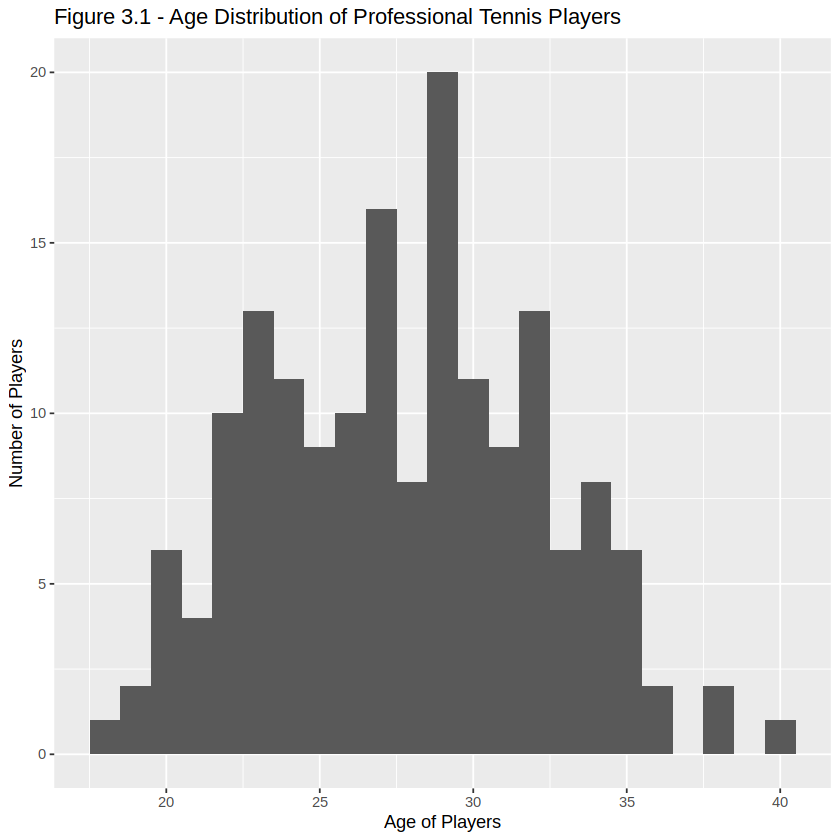

In [52]:
#Plots the distribution of ages across all the players
age_distribution_plot <- player_data_cleaned |>
    ggplot(aes(x=age)) +
    geom_histogram(binwidth=1) +
    labs(x = "Age of Players", y = "Number of Players") +
    ggtitle("Figure 3.1 - Age Distribution of Professional Tennis Players")

age_distribution_plot

From observing the spread of the age of the tennis players, we can clearly see a normal distribution of the data. This is to be expected from age as a variable as most players would be in the middle of their career as a professional tennis player. Additionally, this definitely shows how much age affects the performance of players at certain ages. Next, we can summarize the spread of the data to find the mean and median age of the players. This would be related to our data analysis at a later time. 

In [53]:
age_estimates <- player_data_cleaned |>
    summarize(mean_age = mean(age), median_age = median(age))
age_estimates

mean_age,median_age
<dbl>,<dbl>
27.72024,28


Figure 3.2 Mean and Median Age of the Top Tennis Players

### Splitting the data into training and testing

The next step is to split the data into training and testing data. We split the data so that training data contains 75% of the data set whereas the testing data contains the remaining 25%. Next, we used 5-fold validation to find the optimal K-value for knn-regression. A random set was also selected.

In [54]:
#Splits the data into training and testing sets
set.seed(143) #ensures all randomized functions work the same
data_split <- initial_split(player_data_cleaned, prop = 0.75, strata = prize_money)
player_training <- training(data_split)
player_testing <- testing(data_split)

current_rank_vfold <- vfold_cv(player_training, v = 5, strata = current_rank)
prize_money_vfold <- vfold_cv(player_training, v = 5, strata = prize_money)
current_elo_r_vfold <- vfold_cv(player_training, v = 5, strata = current_elo_rank)

### 4. Initial Data Visualization
The initial data visualization includes:

A. Visualizing the relationship between Age and Prize money

B. Visualizing the relationship between Age and current rank

C. Visualizing the relationship between Age and current elo rank

#### A. Visualizing the relationship between Age and Prize money

The following is a scatter plot that shows the relationship between prize money and age. First, we will plot a scatter plot to see the relationship between prize money and age of the top 500 players. The plot is then scaled.

Saving 6.67 x 6.67 in image


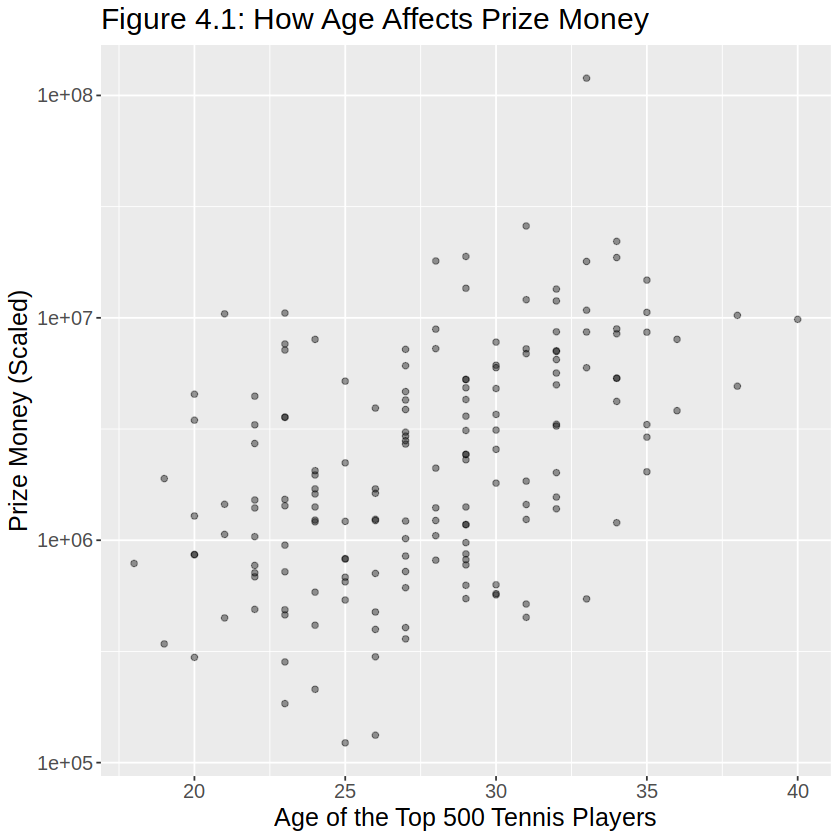

In [55]:
age_money_plot <- player_data_cleaned |>
    ggplot(aes(x=age, y= prize_money))+
    geom_point(alpha=0.4)+
    labs(x="Age of the Top 500 Tennis Players", y= "Prize Money (Scaled)") +
    scale_y_log10() +
    ggtitle("Figure 4.1: How Age Affects Prize Money") +
    theme(text = element_text(size=15))
ggsave("age_money_plot.png",age_money_plot)
age_money_plot

#### B. Visualizing the relationship between Age and current rank

Next, we will see the visualization of the relationship between current rank and age. The same process was used previously.

Saving 6.67 x 6.67 in image


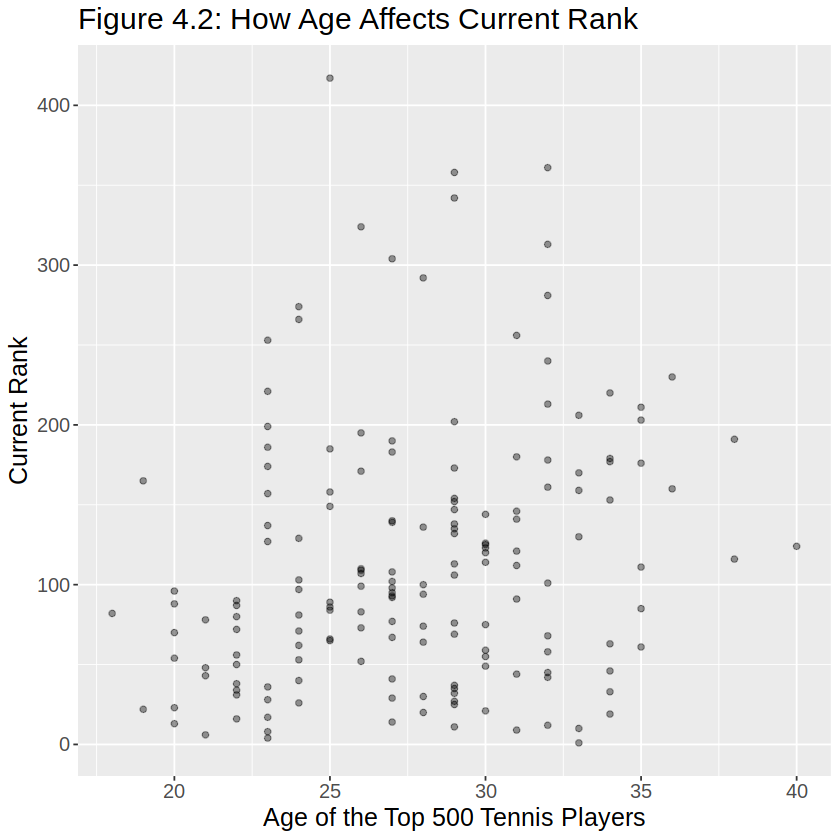

In [56]:
age_rank_plot <- player_data_cleaned |>
    ggplot(aes(x=age, y= current_rank))+
    geom_point(alpha=0.4)+
    labs(x="Age of the Top 500 Tennis Players", y= "Current Rank") +
    ggtitle("Figure 4.2: How Age Affects Current Rank") +
    theme(text = element_text(size=15)) 
ggsave("age_rank_plot.png",age_rank_plot)
age_rank_plot

#### C. Visualizing the relationship between Age and current elo rank

Finally, the relationship between current elo rank and age are as follows...

Saving 6.67 x 6.67 in image


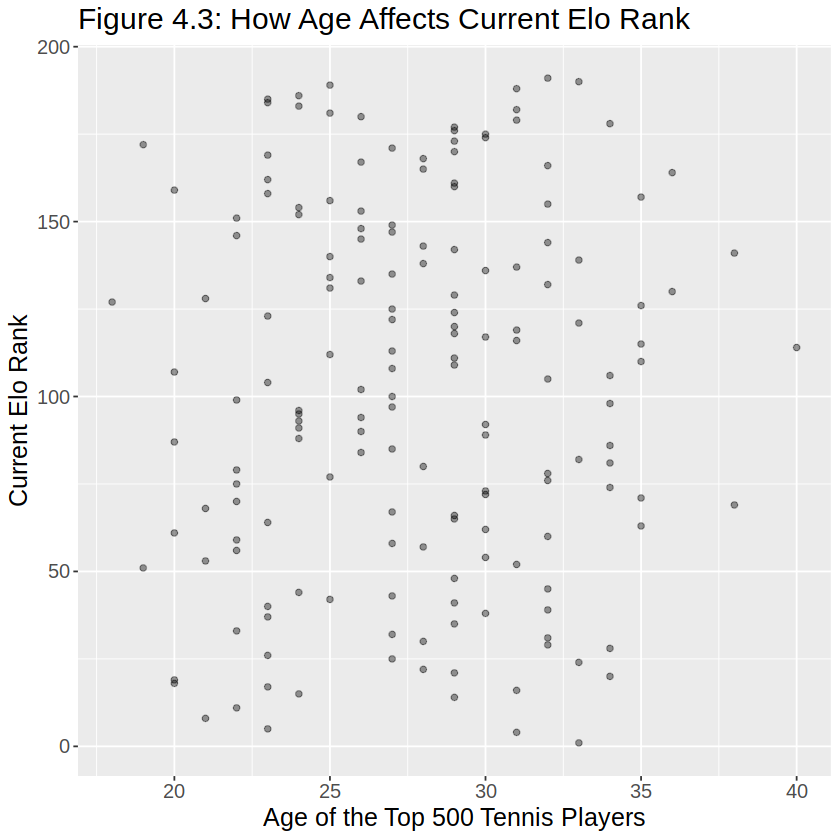

In [57]:
age_elo_plot <- player_data_cleaned |>
    ggplot(aes(x=age, y= current_elo_rank))+
    geom_point(alpha=0.4)+
    labs(x="Age of the Top 500 Tennis Players", y= "Current Elo Rank") +
    ggtitle("Figure 4.3: How Age Affects Current Elo Rank")+
    theme(text = element_text(size=15))
ggsave("age_elo_plot.png", age_elo_plot)
age_elo_plot

### 5. Data Analysis
The data analysis includes:

A. Creating a regression model for Prize Money

B. Creating a regression model for Current Rank

C. Creating a regression model for Current Elo Rank

### A. Creating a regression model for Prize Money

This section will focus on finding the best K value for Prize Money. We included the recipe as well as the model that includes a specification which includes the 5-fold validation by setting `neighbors = tune()`. Additionally, combining the two into a workflow to find K. Which would be the ideal K value for nearest neighbors. 

In [58]:
#KNN Regression on Prize Money
#Pre-process
set.seed(143)
prize_money_recipe <- recipe(prize_money ~ age, data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

prize_money_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

prize_money_wrkflw <- workflow() |>
    add_recipe(prize_money_recipe) |>
    add_model(prize_money_spec)

prize_money_gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

#Results of the Workflow + Finding best N
prize_money_results <- prize_money_wrkflw |>
    tune_grid(resamples = prize_money_vfold, grid = prize_money_gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    arrange(mean) 
head(prize_money_results)

! Fold1: preprocessor 1/1, model 1/1: 96 samples were requested but there were 96 rows in the data. 91 will be...

! Fold2: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold3: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold4: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold5: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
61,rmse,standard,7962378,5,3940136,Preprocessor1_Model13
56,rmse,standard,7986870,5,3920994,Preprocessor1_Model12
36,rmse,standard,7991160,5,3873359,Preprocessor1_Model08
41,rmse,standard,7999370,5,3903931,Preprocessor1_Model09
51,rmse,standard,8005997,5,3918529,Preprocessor1_Model11
46,rmse,standard,8009169,5,3918196,Preprocessor1_Model10


Figure 5.1: Table of K-values in ascending mean value for prize money

Next, we can compare the results of what we found. We can see that the neighbor value of 51 has the lowest mean, which is what we would be looking for. This would make sense as this neighbor value would correspond to the minimum RMSPE value.

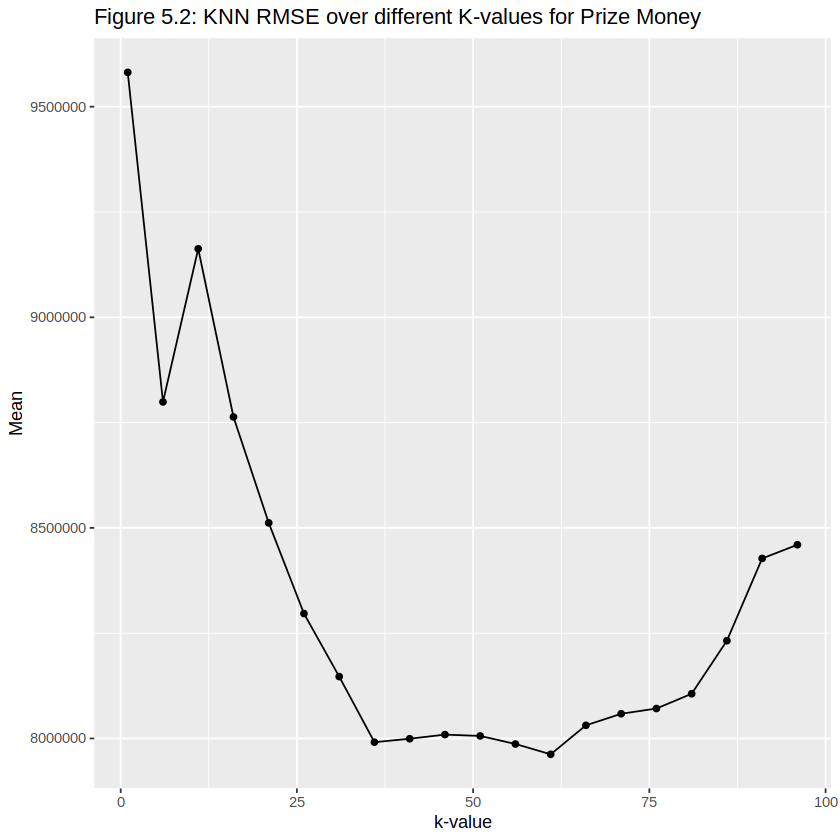

In [59]:
prize_money_k_graph <- ggplot(prize_money_results, aes(x = neighbors, y = mean)) +
        geom_point() + geom_line() +
        labs(title = "Figure 5.2: KNN RMSE over different K-values for Prize Money",
             x = "k-value", y = "Mean")
prize_money_k_graph

To validate that the neighbor best fit would be 51.

In [60]:
prize_money_nvalue <- prize_money_results |>
    slice_min(mean, n =1)

prize_money_nvalue #Best N Value, smallest mean

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
61,rmse,standard,7962378,5,3940136,Preprocessor1_Model13


Figure 5.3 Table for best K-value for prize money

#### Building the Model

Now that we have the best N value for this data set, 51, we are able to create the final workflow for this regression. We created the new model, named `prize_money_spec1`, with the final workflow named `prize_money_fit`. This will be the final model/workflow that is used for the regression for Prize Money. 

In [61]:
#Rerunning the KNN Regression with the best N
set.seed(143)
prize_money_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 51) |>
    set_engine("kknn") |>
    set_mode("regression")

prize_money_fit <- workflow() |>
    add_recipe(prize_money_recipe) |>
    add_model(prize_money_spec1) |>
    fit(data = player_training)
prize_money_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(51,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 3562237
Minimal mean squared error: 1.159988e+14
Best kernel: rectangular
Best k: 51

Next, we can see the predicted prize winnings for each age individually, the process is included below as well as peeking into the tibble.

In [62]:
#Rerunning the KNN Regression with the best N
#predicts associated money values with age, "by=1" so that it predicts for every age
prize_money_predgrid <- tibble(
    age = seq(from = player_data_cleaned |>
    select(age) |>
    min(),
    to = player_data_cleaned |>
    select(age) |>
    max(),
    by = 1))

#combines predicted values with original data frame
prize_money_preds <-prize_money_fit |>
    predict(prize_money_predgrid) |>
    bind_cols(prize_money_predgrid)
head(prize_money_preds)

.pred,age
<dbl>,<dbl>
1609070,18
1609070,19
1609070,20
1609070,21
1609070,22
1661183,23


Figure 5.4: Predicted prize money by age

#### Regression Graph


Now, we can graph the regression line with the data set as seen below. 

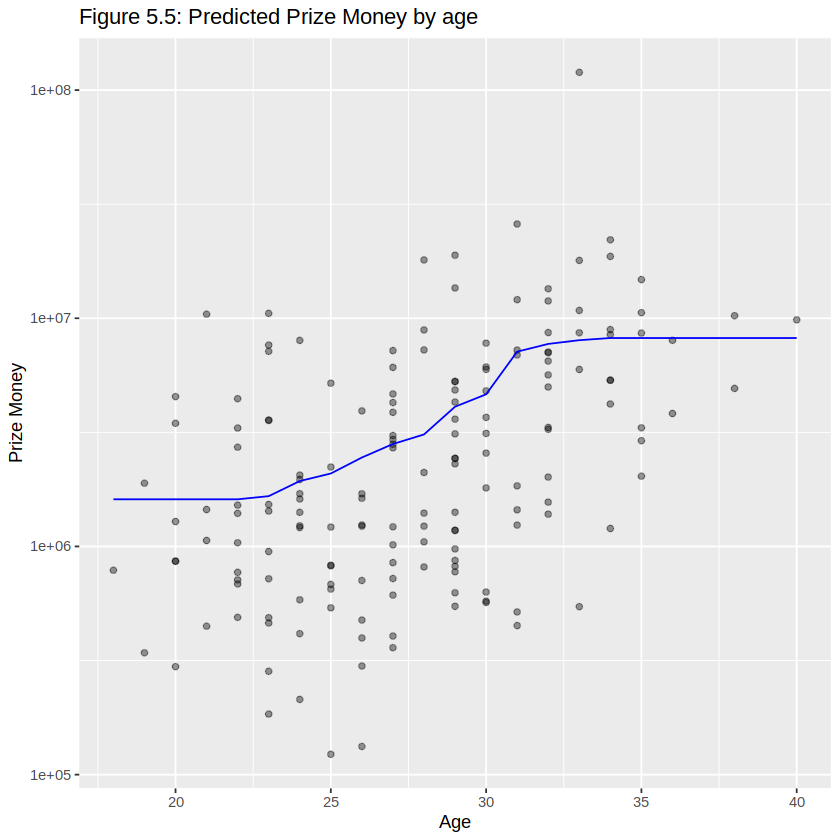

In [64]:
#Graph of the KNN regression
prize_money_final <- player_data_cleaned |>
    ggplot(aes(x = age, y = prize_money)) +
    geom_point(alpha = 0.4) +
    geom_line(data = prize_money_preds,
              mapping = aes(x = age, y = .pred),
              colour = "blue") +
    labs(x = "Age", y = "Prize Money", title="Figure 5.5: Predicted Prize Money by age") +
    scale_y_log10()
prize_money_final

### B. Creating a regression model for Current Rank

The same process to find the best K value for Current Rank will be the same as finding the best K value for Prize Money.

In [65]:
#KNN Regression on Current Rank
#Pre-process
set.seed(143)
current_rank_recipe <- recipe(current_rank ~ age, data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

current_rank_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

current_rank_wrkflw <- workflow() |>
    add_recipe(current_rank_recipe) |>
    add_model(current_rank_spec)

current_rank_gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

#Results of the Workflow + Finding best N
current_rank_results <- current_rank_wrkflw |>
    tune_grid(resamples = current_rank_vfold, grid = current_rank_gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    arrange(mean)
head(current_rank_results)

! Fold1: preprocessor 1/1, model 1/1: 96 samples were requested but there were 96 rows in the data. 91 will be...

! Fold2: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold3: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold4: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold5: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
71,rmse,standard,78.68137,5,6.034255,Preprocessor1_Model15
81,rmse,standard,78.69769,5,5.852418,Preprocessor1_Model17
86,rmse,standard,78.73867,5,5.834473,Preprocessor1_Model18
76,rmse,standard,78.84927,5,5.875637,Preprocessor1_Model16
91,rmse,standard,79.01834,5,5.870208,Preprocessor1_Model19
96,rmse,standard,79.13521,5,5.903270,Preprocessor1_Model20


Figure 5.6: Table of K-values in ascending mean value for current rank

Now, we can graph the mean along the neighbor value to find the optimal neighbor values.

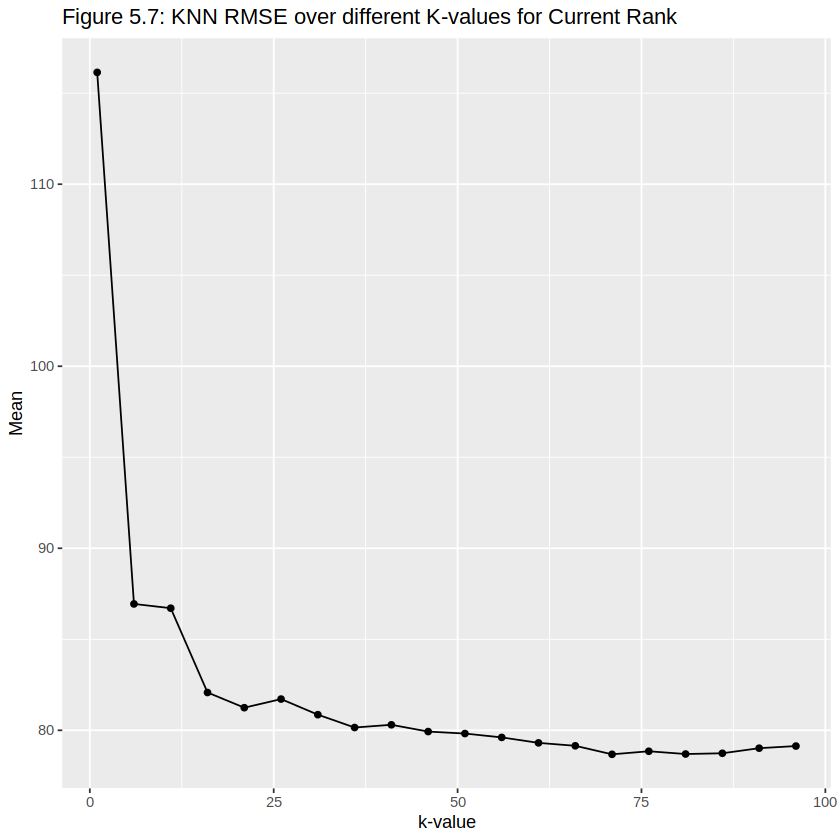

In [66]:
current_rank_k_graph <- ggplot(current_rank_results, aes(x = neighbors, y = mean)) +
        geom_point() + geom_line() +
        labs(title = "Figure 5.7: KNN RMSE over different K-values for Current Rank",
             x = "k-value", y = "Mean")
current_rank_k_graph

In [67]:
current_rank_nvalue <- current_rank_results |>
    slice_min(mean, n =1)

current_rank_nvalue #Best N Value, smallest mean

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
71,rmse,standard,78.68137,5,6.034255,Preprocessor1_Model15


Figure 5.8: Best N value for current rank

#### Building the Model

Now that we have the best neighbor value of 71, we can create the new model with the ideal neighbor value. As well as building the final workflow for this section.

In [68]:
#Rerunning the KNN Regression with the best N
current_rank_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 71) |>
    set_engine("kknn") |>
    set_mode("regression")

current_ranking_fit <- workflow() |>
    add_recipe(current_rank_recipe) |>
    add_model(current_rank_spec1) |>
    fit(data = player_training)
current_ranking_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(71,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 61.08542
Minimal mean squared error: 6323.375
Best kernel: rectangular
Best k: 71

Next, we apply the workflow to the cleaned data to find the predicted ranking for each age, we see how the ranking for those who are at lower ranking are older in comparison to those who are younger.

In [69]:
#predicts associated rank values with age, "by=1" so that it predicts for every age
currentrank_predgrid <- tibble(
    age = seq(from = player_data_cleaned |>
    select(age) |>
    min(),
    to = player_data_cleaned |>
    select(age) |>
    max(),
    by = 1))

#combines predicted values with original data frame
current_ranking_preds <- current_ranking_fit |>
    predict(currentrank_predgrid) |>
    bind_cols(currentrank_predgrid)
tail(current_ranking_preds)
head(current_ranking_preds)

.pred,age
<dbl>,<dbl>
122.6901,35
122.6901,36
122.6901,37
122.6901,38
122.6901,39
122.6901,40


.pred,age
<dbl>,<dbl>
100.8732,18
100.8732,19
100.8732,20
100.8732,21
100.8732,22
100.8732,23


Figure 5.9: Predicted Current rank by age

#### Regression Graph

Next, included is the regression graph which predicts current rank by age.

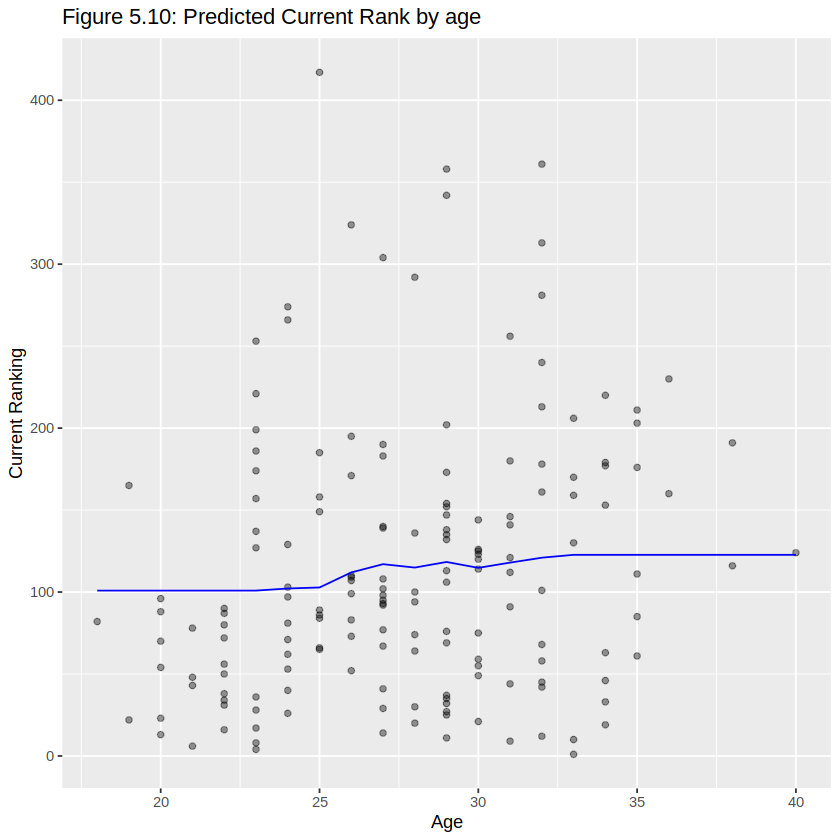

In [70]:
#Graph of the KNN regression
current_ranking_final <- player_data_cleaned |>
    ggplot(aes(x = age, y = current_rank)) +
    geom_point(alpha = 0.4) +
    geom_line(data = current_ranking_preds,
              mapping = aes(x = age, y = .pred),
              colour = "blue") +
    labs(x = "Age", y = "Current Ranking", title="Figure 5.10: Predicted Current Rank by age") 
current_ranking_final

### 3. Creating a regression model for Elo Rank

The same process is applied for this model to predict Current Rank with age. We see how we are finding the optimal K value once again...

In [71]:
set.seed(143)

#KNN Regression on Current Elo Ranking
#Pre-process
current_elo_r_recipe <- recipe(current_elo_rank ~ age, data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

current_elo_r_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

current_elo_r_wrkflw <- workflow() |>
    add_recipe(current_elo_r_recipe) |>
    add_model(current_elo_r_spec)

current_elo_r_gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

#Results of the Workflow + Finding best N
current_elo_r_results <- current_elo_r_wrkflw |>
    tune_grid(resamples = current_elo_r_vfold, grid = current_elo_r_gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    arrange(mean)
head(current_elo_r_results)

! Fold1: preprocessor 1/1, model 1/1: 96 samples were requested but there were 96 rows in the data. 91 will be...

! Fold2: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold3: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold4: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...

! Fold5: preprocessor 1/1, model 1/1: 96 samples were requested but there were 100 rows in the data. 95 will b...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,rmse,standard,52.46328,5,1.587139,Preprocessor1_Model17
91,rmse,standard,52.47450,5,1.494420,Preprocessor1_Model19
96,rmse,standard,52.51282,5,1.481795,Preprocessor1_Model20
86,rmse,standard,52.54038,5,1.528476,Preprocessor1_Model18
51,rmse,standard,52.66872,5,1.285814,Preprocessor1_Model11
61,rmse,standard,52.69265,5,1.440051,Preprocessor1_Model13


Figure 5.11: Table of K-values in ascending mean value for current elo rank

We can also graph the mean with neighbor values. We see how a neighbor value of 81 has the lowest mean which would correlate to the value in which we would use.

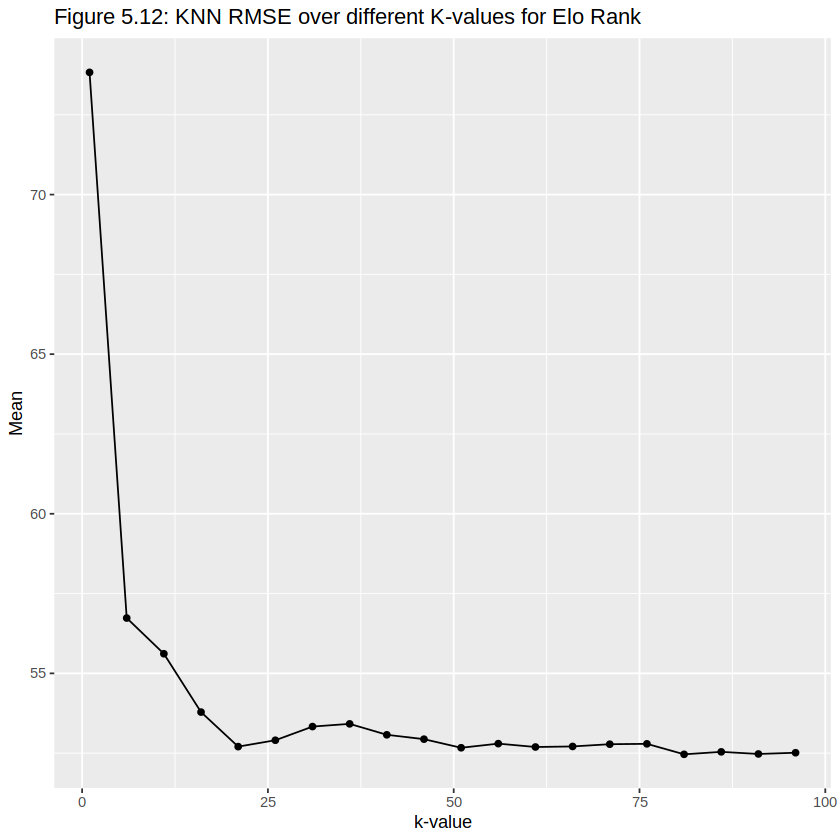

In [73]:
current_elo_rank_k_graph <- ggplot(current_elo_r_results, aes(x = neighbors, y = mean)) +
        geom_point() + geom_line() +
        labs(title = "Figure 5.12: KNN RMSE over different K-values for Elo Rank",
             x = "k-value", y = "Mean")
current_elo_rank_k_graph

In [74]:
current_elo_r_nvalue <- current_elo_r_results |>
    slice_min(mean, n =1)

current_elo_r_nvalue #Best N Value, smallest mean

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,rmse,standard,52.46328,5,1.587139,Preprocessor1_Model17


Figure 5.12: Best N value for current elo rank

The neighbors with the lowest mean is 81, meaning that the neighbor value we will use for the final model is 81.

#### Building the Model

A new model was created with the new neighbor value, we will then create a new workflow using the model.

In [75]:
#Rerunning the KNN Regression with the best N
current_elo_r_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 81) |>
    set_engine("kknn") |>
    set_mode("regression")

current_elo_r_fit <- workflow() |>
    add_recipe(current_elo_r_recipe) |>
    add_model(current_elo_r_spec1) |>
    fit(data = player_training)

#predicts associated rank values with age, "by=1" so that it predicts for every age
current_elo_r_predgrid <- tibble(
    age = seq(from = player_data_cleaned |>
    select(age) |>
    min(),
    to = player_data_cleaned |>
    select(age) |>
    max(),
    by = 1))

#combines predicted values with original data frame
current_elo_r_preds <- current_elo_r_fit |>
    predict(current_elo_r_predgrid) |>
    bind_cols(current_elo_r_predgrid)
head(current_elo_r_preds)
tail(current_elo_r_preds)

.pred,age
<dbl>,<dbl>
103.3704,18
103.3704,19
103.3704,20
103.3704,21
103.3704,22
103.3704,23


.pred,age
<dbl>,<dbl>
100.8025,35
100.8025,36
100.8025,37
100.8025,38
100.8025,39
100.8025,40


Figure 5.13: Predicted Current Elo Rank by age

#### Regression Graph

Included below is the graph and visualization of the data set with the regression line.

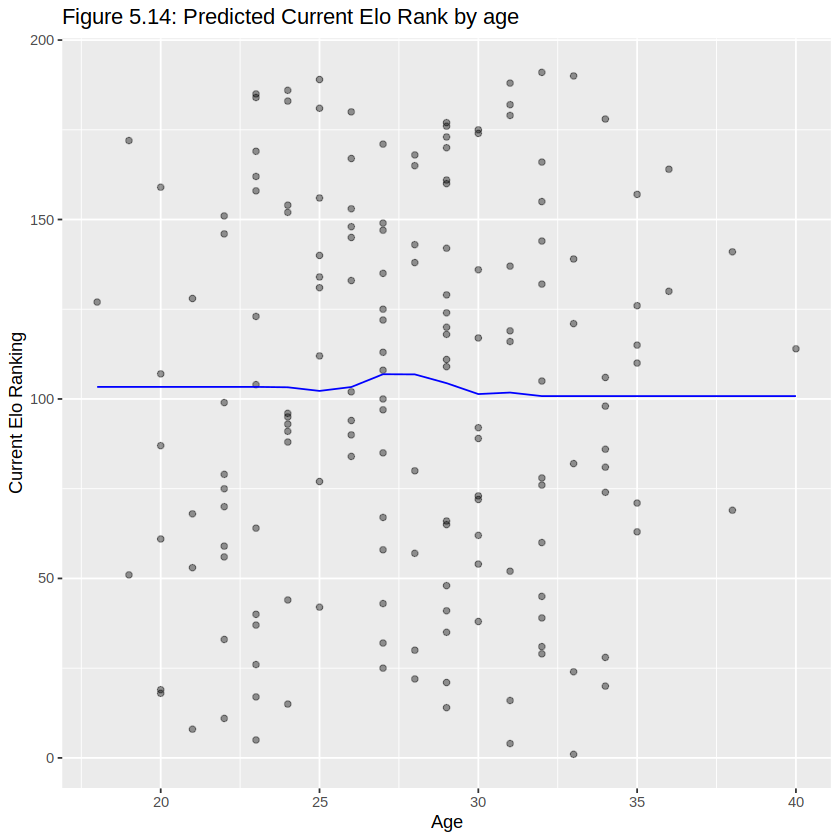

In [77]:
#Graph of the KNN regression
current_elo_r_final <- player_data_cleaned |>
    ggplot(aes(x = age, y = current_elo_rank)) +
    geom_point(alpha = 0.4) +
    geom_line(data = current_elo_r_preds,
              mapping = aes(x = age, y = .pred),
              colour = "blue") +
    labs(x = "Age", y = "Current Elo Ranking", title="Figure 5.14: Predicted Current Elo Rank by age") 
current_elo_r_final

## Discussion

### Summary of Results

We found that among the top tennis players, the mean age is 27.7 years old which is similar to that of other demanding sports such as basketball, football and badminton (Andy; Speros; Pronnoy) implying that retiring young may not be unique to tennis. 

We found that age can adequately predict prize money. As seen in the graph, all players younger than around 23 years old have accumulated around 1.8 million USD in prize money. After, prize money seems to steadily increase with age but plateaus at around 32.5 years old at nearly 8 million USD. In contrast, age seems to have very little predictive power on current rank and elo rank. With current rank, similar to prize money, all players seem to have a rank of around 100 until approximately age 25, where players’ current ranks appears to slightly increase until it reaches a plateau at rank 125 at around 32.5 years old. The brief increase observed in the graph however is not as consistent as compared to that of prize money. Current elo rank appears to have even lower predictive power as players seem to rank at around 100 regardless of age, except for a sudden increase at around age 27 to approximately rank 110. 


### Interpreting Results and Implications

The results for prize money are consistent with our original hypothesis since accumulated prize money seems to increase with age as players have played more tournaments. This allows tennis players to expect a rather stagnant income up until their early 20s, knowing that this is a common trend amongst players can reduce the pressure put on players to succeed at a young age. While the steady increase between ages 23 and 32.5 may indicate a range of “prime” years for earning prize money for players to expect. The plateau thereafter may help players decide at what age to retire. 

With current rank and current elo rank, though there is a slight drop in rank with age in the former, top tennis players appear to maintain a rank of around 100 to 125 regardless of age. This does not support our hypothesis. One reason may be the anti-aging effects of tennis, with a recent study finding that playing tennis can extend one’s life by 10 years (Schnohr et al.), decreasing the difference in physical abilities between younger and older players. Another possible explanation may be that, while younger players may have greater physical prowess, older players would likely make up for that discrepancy with greater skills or by using less demanding playstyles. 


### Suggestions for Future Research

Given that our data set consists solely of the top tennis players, these conclusions may not be as applicable to all tennis players. One may expand on our research by using a data set with more players of differing ranks. Additionally, a possibility for future research is to conduct a cluster analysis allowing us to better understand whether certain age groups tend to place at certain ranks or have accumulated certain amounts of prize money. 

## Works Cited

_Ultimate Tennis Statistics_, https://www.ultimatetennisstatistics.com. Accessed 8 December 2023.

Andy. “How Old Are NBA Players on Average? Analysis from 1952-2022.” _The Hoops Geek_, 24 August 2022, https://www.thehoopsgeek.com/average-age-nba-players/. Accessed 8 December 2023.

“How does ageing change sport performance?” _Research Outreach_, 7 May 2020, https://researchoutreach.org/articles/ageing-change-sport-performance-master-athletes-answer/. Accessed 6 December 2023.

Jenkin, Claire R., et al. “Sport and ageing: a systematic review of the determinants and trends of participation in sport for older adults.” _BMC Public Health_, vol. 17, no. 1, 2017. _PubMed_, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5741887/.

Pronnoy, K. “Badminton Player Statistics: Rankings, Earnings & Demographics 2022.” _Badminton Weekly_, 29 September 2022, https://badmintonweekly.com/player-statistics/. Accessed 8 December 2023.

Schnohr, Peter, et al. “Various Leisure-Time Physical Activities Associated With Widely Divergent Life Expectancies: The Copenhagen City Heart Study.” _Mayo Clinic Proceedings_, vol. 93, no. 12, 2018, pp. 1775-1785. _Mayo Clinic Proceedings_, https://www.mayoclinicproceedings.org/article/S0025-6196(18)30538-X/fulltext.

Speros, Bill. “Average Age of Each NFL Team In 2023: Oldest & Youngest.” _Bookies_, 31 August 2023, https://bookies.com/nfl/picks/nfl-teams-average-age. Accessed 8 December 2023.

Walker, Randy. “Are Tennis Stars Getting Younger?” _World Tennis Magazine_, 20 December 2022, https://www.worldtennismagazine.com/archives/21560. Accessed 6 December 2023.